## Get imaging frames corresponding to stimulation epochs

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from fish.image.zds import ZDS
from fish.util.plot import proj_fuse
from fish.util.fileio import read_image
from fish.ephys.ephys import load, estimate_onset, chop_trials
from skimage.io import imsave
from glob import glob
from glymur import jp2k
import thunder as td
from os.path import exists
from os import makedirs
%matplotlib inline

In [2]:
def guess_experimenter(fname):
        if fname.find('Yu') > 0:
            return 'yu'
        elif fname.find('davis') > 0:
            return 'davis'
        else:
            return ''

def get_trials(v, trials, window):
    from numpy import concatenate, array    
    result = []
    inds = array([tr + window for tr in trials])
    inds = list(filter(lambda x: x.max() < len(v), inds))
    inds = list(filter(lambda x: x.min() > 0, inds))
    
    for ind in inds:
        result.append(v[ind])
    return concatenate(result)

def match_cam_time(events, cam, timing):
    from numpy import array
    output = []
    for a in events:
        lags = array([a-b for b in cam])
        before = len(lags[lags > 0]) - 1
        after = before + 1
        
        if (before >= 0) and (after < len(cam)):
            if timing == 'pre':                
                output.append(before)
            if timing == 'post':
                output.append(after)    
    return array(output)


def parf(function, image, num_cores):
    # parallelize application of a function across z planes
    from numpy import array
    from joblib import Parallel, delayed
    return array(Parallel(n_jobs=num_cores)(delayed(function)(i) for i in image))


def tidy_up_mask(im):
    from skimage.morphology import disk, binary_opening, remove_small_objects, remove_small_holes
    im_ = im.copy()
    im_ = binary_opening(im_, disk(3))
    im_ = remove_small_objects(im_, min_size=500)
    im_ = remove_small_holes(im_, min_size=100000)
    return im_

In [58]:
base_dirs = ('/nrs/ahrens/davis/data/spim/raw/20180321/f1/5dpf_ec43xcy331xcy171_f1_opto_1_20180321_115401/',
        '/nrs/ahrens/davis/data/spim/raw/20180321/f1/5dpf_ec43xcy331xcy171_f1_opto_2_20180321_162917/',
        '/nrs/ahrens/davis/data/spim/raw/20180321/f2/5dpf_ec43xcy331xcy171_f2_opto_1_20180321_180812/',
        '/nrs/ahrens/davis/data/spim/raw/20180321/f2/5dpf_ec43xcy331xcy171_f2_opto_1_20180321_180812/')

# do different things to the directories depending on whether data are davis' or yu's
paths = dict()
cur_exp = 3
paths['base'] = base_dirs[cur_exp]
experimenter = guess_experimenter(paths['base'])

bidirectional_stack=False

if experimenter is 'yu':
    print('These data are from Yu.')
    paths['raw'] = paths['base'] + 'raw/'
    # need to deal with permissions for some data, so results will be in a temporary folder
    paths['reg'] = '/groups/ahrens/ahrenslab/davis/tmp/' + paths['base'].split(sep)[-2] + sep
        
elif experimenter is 'davis':
    print('These data are from Davis')    
    paths['raw'] = paths['base']
    paths['proc'] = paths['raw'].replace('raw', 'proc')
    paths['reg'] = paths['proc'] + 'reg/'
    paths['opto'] = paths['proc'] + 'opto/'

dset = ZDS(paths['raw'])
background_im_fname = paths['raw'] + 'Background_0.tif'
background_im = jp2k.Jp2k(background_im_fname)[:]

print('Num raw images: {0}'.format(dset.shape[0]))

fs_im = dset.metadata['volume_rate']    
print('Sampling rate:  {0} Hz'.format(fs_im))

bidirectional_stack = (dset.metadata['bidirectional_stack'] == 'T')
z_step = dset.metadata['z_step']
aspect = (int(z_step / .406), 1, 1)

from os.path import exists
from os import makedirs
if not exists(paths['proc']):
    makedirs(paths['proc'])
if not exists(paths['opto']):
    makedirs(paths['opto'])
print('Bidirectional stack : {0}'.format(bidirectional_stack))

These data are from Davis
Num raw images: 3375
Sampling rate:  1.87 Hz
Bidirectional stack : False


# Get trial structure

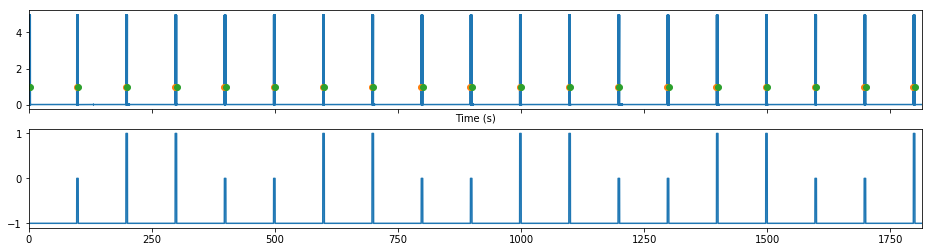

In [59]:
ep_dat = load('/groups/ahrens/ahrenslab/davis/data/ephys/20180321/f2/5dpf_ec43xcy331xcy171_f2_opto_2.10chFlt')
fs_ep = 6000
cam_times = estimate_onset(ep_dat[2], threshold=3.7, duration=100)
laser_on = estimate_onset(ep_dat[3], threshold=3.7, duration=4000)
# Run the onset detection on the flipped data to get offsets
laser_off = len(ep_dat[3]) - estimate_onset(ep_dat[3][::-1], threshold=3.7, duration=4000)
laser_off = laser_off[::-1]
# ignore optostim that happened outside the imaging timeframe
laser_off = laser_off[laser_off < cam_times[-1]]
laser_on = laser_on[:len(laser_off)]

trials = chop_trials(ep_dat[4])
# for each trial onset look for the nearest cam time before the onset.
# for each offset, look for the nearest cam time after offset
trials_cam = {}

for key, val in trials.items():
    if key > -1:
        pre = match_cam_time(val[0], cam_times, timing='pre')
        post = match_cam_time(val[1], cam_times, timing='post')
        trials_cam[int(key)] = [pre, post]
        
fig, axs = plt.subplots(nrows=2, figsize=(16,4), sharex=True)
plr = np.arange(0, cam_times[-1])
plr_t = plr/fs_ep
axs[0].plot(plr_t, ep_dat[3][plr])
axs[0].plot(plr_t[laser_on], 1 + laser_on * 0, 'o')
axs[0].plot(plr_t[laser_off], 1 + laser_on * 0, 'o')
axs[0].set_xlim(plr_t.min(), plr_t.max())
axs[0].set_xlabel('Time (s)')

axs[1].plot(plr_t, ep_dat[4][plr])

Get times when different ROI were stimulated.
Trial timing is sufficiently close to laser timing, so we can just use the time trials started / stopped as a proxy for laser stimulation timing

# Image preprocessing

In [60]:
plr = slice(0, None)
ims = td.images.fromlist(dset.files[plr], accessor=read_image, engine=sc, npartitions=len(dset.files[plr])).median_filter(size=(1,3,3)).astype('float32')
if bidirectional_stack:
    from fish.image.vol import rearrange_bidirectional_stack
    ims = ims.map(rearrange_bidirectional_stack)

In [61]:
%%time
do_registration = False

if not exists(paths['reg']):
    ref_range = (dset.shape[0] // 2) + np.arange(-5,5)
    ref = td.images.fromlist(dset.files[ref_range], accessor=read_image)
    ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('uint16')

    if bidirectional_stack:
        ref = rearrange_bidirectional_stack(ref)

    # save reference image to disk 

    makedirs(paths['reg'])
    imsave(paths['reg'] + 'anat_reference.tif', ref, compress=1)
else:
    from skimage.io import imread
    ref = imread(paths['reg'] + 'anat_reference.tif')

try:
    affs = np.load(paths['reg'] + 'regparams_affine.npy')
    affs = affs[plr]
    print('Registration params found')
except(FileNotFoundError):
    print('Registration params not found, performing registration')
    do_registration = True

if do_registration:
    from fish.image.alignment import estimate_translation
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    affs = np.array([r.affine for r in reg])
    np.save(paths['reg'] + 'regparams_affine.npy', affs)

Registration params found
CPU times: user 8.21 ms, sys: 245 ms, total: 254 ms
Wall time: 260 ms


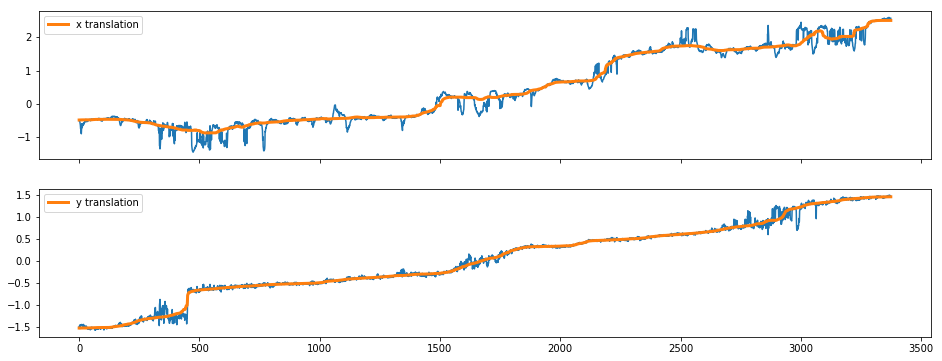

In [62]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6), sharex=True)
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=200)
y_trans = median_filter(y_trans_raw, size=200)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
[ax.legend() for ax in axs]

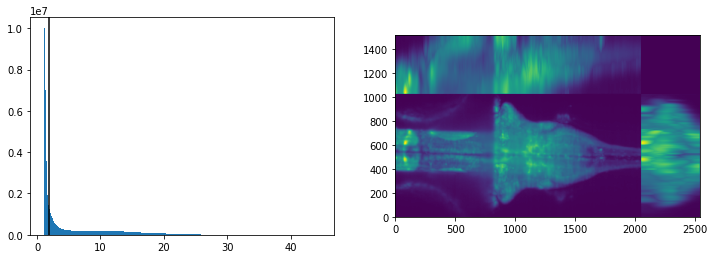

In [63]:
from fishtrack.util import long_tail_threshold
from scipy.ndimage.filters import gaussian_filter
ref_filt = gaussian_filter(ref.astype('float32'), sigma=[5,5,5])
thr_ = long_tail_threshold(ref_filt.ravel(), nbins=100, shrink_factor=1)

fig, axs = plt.subplots(ncols=2, figsize=(12,4))
axs[0].hist(ref_filt.ravel(), 512);
axs[0].axvline(thr_, color='k')
axs[1].imshow(proj_fuse(ref_filt, np.max, aspect=aspect, fill_value=ref_filt.min()), origin='lower')

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a bool

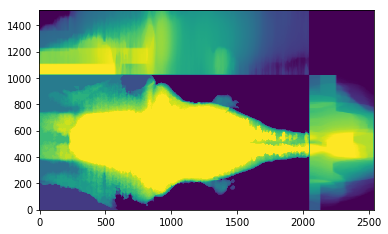

In [64]:
mask = parf(tidy_up_mask, ref_filt > (thr_ * 1.02), 16);
fill_val = int(ref[~mask].mean());

y_lim = 1 + np.abs(np.array([min(trans[1,:]), max(trans[1,:])])).astype('int')
x_lim = 1 + np.abs(np.array([min(trans[2,:]), max(trans[2,:])])).astype('int')

if x_lim[0] > 0:
    mask[:,:,:x_lim[0]] = False
if x_lim[1] > 0:
    mask[:,:,-x_lim[1]:] = False
if y_lim[0] > 0:
    mask[:,:y_lim[0],:] = False
if y_lim[1]  > 0:
    mask[:,-y_lim[1]:,:] = False

plt.imshow(proj_fuse(mask, np.mean, aspect=aspect), origin='lower');

# Save mask to disk
from skimage.io import imsave
imsave(paths['opto'] + 'mask.tif', mask.astype('uint8'))

In [65]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=fill_val, order=1), with_keys=True).astype('float32')

In [66]:
%%time
# take 300s baseline
from fish.image.vol import filter_flat, unfilter_flat
from fish.image.vol import dff
from skimage.transform import downscale_local_mean
from functools import partial
baseline_window = int(300 * fs_im)
baseline_offset = 10
mydff = partial(dff, window=baseline_window, percentile=20, baseline_offset=baseline_offset)
ds = 2

# subtract camera background, clip off negative values
ims_reg_bs = ims_registered.map(lambda v: np.clip(v - fill_val, a_min=0, a_max=None))

# uniform filter and downsampling
ims_ds = ims_reg_bs.map(lambda v: downscale_local_mean(v, factors=(1,ds,ds)))

#take dff only of masked pixels by filtering on keys using mask coords
mask_ds = mask[:,::ds,::ds]
mask_ds_bc = sc.broadcast(mask_ds)

ims_flat = ims_ds.map(lambda v: filter_flat(v, mask_ds_bc.value))
ser = ims_flat.toseries().map(mydff).cache()
ser.count()

CPU times: user 10.2 s, sys: 1.03 s, total: 11.2 s
Wall time: 31min 28s


# Perform triggered windowing

In [ ]:
av_window = np.arange(int(-5 * fs_im), int(30 * fs_im))

In [ ]:
%%time
from os.path import exists
from os import mkdir
for tr in trials_cam.keys():
    out_path = paths['opto'] + 'condition_{0}/'.format(tr)
    if not exists(out_path):
        mkdir(out_path)
    windowed_trial = ser.map(lambda v: get_trials(v, trials_cam[tr][0], av_window))    
    windowed_trial.toimages().tordd().foreach(lambda kv: np.save(out_path + 't_{0:05d}.npy'.format(kv[0][0]), kv[1]))
    
np.save(paths['opto'] + 'av_window.npy', av_window)

In [ ]:
%%bash
bkill 0